# Watchlist and (MOC) Area hits
### Ken Smith
This code gets a previously defined area on the sky with [MOC](https://cds-astro.github.io/mocpy/) (multi-order coverage maps), an [IVOA standard](https://ivoa.net/documents/MOC/) and grabs the ZTF objects that lie within that area that are also in a watchlist.  The code is in development, but for more information on converting (e.g.) Healpix maps of GW events to MOCs, feel free to get in touch.

We have defined the SDSS footprint within Lasair as https://lasair-ztf.lsst.ac.uk/area/2/ (area number 2).  The area number is needed for the SQL query later on.  Likewise, we also have a predefined watchlist of BLLacs https://lasair-ztf.lsst.ac.uk/watchlist/35/ (number 35).  In the current implementation, the watchlist number is also required later.

Demonstrates usage of:
* Area Hits
* Watchlist Hits
* /query/
* /objects/

This code demonstrates a query that can check a watchlist for ZTF hits that also overlap a previously defined area of the sky - e.g. GW 90% contour or SDSS area.  See https://lasair-ztf.lsst.ac.uk/area/ and https://lasair-ztf.lsst.ac.uk/watchlist/.


In [15]:
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
from lasair import LasairError, lasair_client as lasair
import pandas as pd

### Make an SQL query
We are going to make an SQL query that includes a watchlist and a watchmap. 
Find the ones you like on the Lasair website ([public Watchlists](https://lasair-ztf.lsst.ac.uk/watchlists/), [public Watchmaps](https://lasair-ztf.lsst.ac.uk/watchmaps/)), and change these id numbers appropriately.

In [2]:
ar_id = 116
print('See here for info: https://lasair-ztf.lsst.ac.uk/watchmaps/%d/' % ar_id)

wl_id = 139
print('See here for info: https://lasair-ztf.lsst.ac.uk/watchlists/%d/' % wl_id)

See here for info: https://lasair-ztf.lsst.ac.uk/watchmaps/116/
See here for info: https://lasair-ztf.lsst.ac.uk/watchlists/139/


In [3]:
selected = """
objects.objectId,
objects.ramean,
objects.decmean,
objects.jdmin - 2400000.5 AS mjdmin,
objects.jdmax - 2400000.5 AS mjdmax,
objects.magrmin,
objects.rmag,
sherlock_classifications.classification,
IF(objects.distpsnr1 < 2 AND objects.sgscore1 > 0.49, "PS1_star", "Not_PS1_star") score
"""

tables = 'objects,sherlock_classifications,watchlists:%d,areas:%d' % (wl_id, ar_id)

# Lasair will attempt to join the tables internally without the need to specify
# explicit join conditions, unless you wish to restrict the results further.
conditions = """
sherlock_classifications.classification in ('SN', 'NT', 'AGN')
"""


L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")
try:
    results = L.query(selected, tables, conditions, limit = 20)
except LasairError as e:
    print(e)


In [5]:
# Did we get anything - just crudely print out the results if so.
for row in results:
    try:
        print(row['objectId'],
              "%.5f" % row['ramean'],
              "%.5f" % row['decmean'],
              "%.5f" % row['mjdmin'],
              "%.5f" % row['mjdmax'],
              "%.2f" % row['magrmin'],
              "%.2f" % row['rmag'],
              row['classification'],
              row['score'])
    except TypeError:
        print(row['objectId'],
              row['ramean'],
              row['decmean'],
              row['mjdmin'],
              row['mjdmax'],
              row['magrmin'],
              row['rmag'],
              row['classification'],
              row['score'])

ZTF17aaaadix 75.12347 44.35463 60631.30503 60652.20108 19.45 20.12 SN PS1_star
ZTF17aaaadqv 71.60801 44.11276 60379.17581 60390.15998 18.53 19.51 SN Not_PS1_star
ZTF17aaaafup 82.7761669 23.7206974 60606.40408559982 60606.40408559982 None None SN PS1_star
ZTF17aaaajfc 325.68413 47.15377 60675.09453 60684.11802 15.72 16.42 SN PS1_star
ZTF17aaaajuf 43.92101 -10.48975 58388.52328 59220.21404 17.30 19.16 NT Not_PS1_star
ZTF17aaaazvg 324.92068 45.64403 60592.20150 60614.23882 18.95 18.95 SN PS1_star
ZTF17aaabcyg 325.2470203 48.2919921 60207.24124999996 60207.24124999996 None None SN PS1_star
ZTF17aaabfbg 115.59396 17.46855 60608.40817 60624.52494 18.78 18.78 AGN PS1_star
ZTF17aaabhnn 59.40338 12.40868 60654.17380 60683.32124 18.06 18.06 AGN PS1_star
ZTF17aaabjcs 80.79588 43.38281 60554.43512 60554.43512 19.59 19.59 SN Not_PS1_star
ZTF17aaabjzl 83.27872 24.47581 60562.43197 60562.43197 19.89 19.89 SN PS1_star
ZTF17aaablao 58.85426 45.59752 60192.44632 60211.40949 19.30 19.30 SN Not_PS1_star
Z

### Grab the lightcurves using the objects API

Here we are using the `.objects` method instead of the `.lightcurves` method because the latter can only handle 10 or fewer objectIds and you'll get the following error:

`LasairError: Method can only handle 10 or less objectIds`

In [6]:
objectList = [row['objectId'] for row in results]
objectList = ','.join(objectList)
print('Comma-separated list: ', objectList)

Comma-separated list:  ZTF17aaaadix,ZTF17aaaadqv,ZTF17aaaafup,ZTF17aaaajfc,ZTF17aaaajuf,ZTF17aaaazvg,ZTF17aaabcyg,ZTF17aaabfbg,ZTF17aaabhnn,ZTF17aaabjcs,ZTF17aaabjzl,ZTF17aaablao,ZTF17aaabneq,ZTF17aaabolo,ZTF17aaabonq,ZTF17aaabswj,ZTF17aaabtql,ZTF17aaaccbx,ZTF17aaacdqd,ZTF17aaacfxd


In [7]:
response = L.objects(objectList)

In [16]:
pd.DataFrame(response[0]['candidates'])

,candid,jd,ra,dec,fid,nid,magpsf,sigmapsf,magnr,sigmagnr,...,ssdistnr,ssnamenr,drb,json,mjd,imjd,since_now,utc,image_urls,diffmaglim
0,2.898201e+18,2.460653e+06,75.123428,44.354642,2,2898.0,20.124720,0.209734,20.049,0.04,...,-999.0,null,NaN,"\n ""candid"": 2898201070215010006,\n ""jd"": 24...",60652.201076,60652,-32.208943,2024-12-08 04:49:33,{'Science': 'https://lasair-ztf.lsst.ac.uk/las...,NaN
1,NaN,2.460651e+06,NaN,NaN,1,NaN,20.467800,NaN,NaN,NaN,...,NaN,NaN,NaN,"\n ""jd"": 2460650.8852315,\n ""fid"": 1,\n ""di...",60650.385232,60650,-34.024788,NaN,NaN,20.467800
2,NaN,2.460651e+06,NaN,NaN,2,NaN,20.157301,NaN,NaN,NaN,...,NaN,NaN,NaN,"\n ""jd"": 2460650.7432755,\n ""fid"": 2,\n ""di...",60650.243275,60650,-34.166744,NaN,NaN,20.157301
3,NaN,2.460649e+06,NaN,NaN,1,NaN,20.670099,NaN,NaN,NaN,...,NaN,NaN,NaN,"\n ""jd"": 2460648.8439236,\n ""fid"": 1,\n ""di...",60648.343924,60648,-36.066096,NaN,NaN,20.670099
4,NaN,2.460649e+06,NaN,NaN,2,NaN,20.583700,NaN,NaN,NaN,...,NaN,NaN,NaN,"\n ""jd"": 2460648.7388194,\n ""fid"": 2,\n ""di...",60648.238819,60648,-36.171200,NaN,NaN,20.583700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,5.964883e+17,2.458351e+06,75.123429,44.354603,2,596.0,20.169500,0.172561,20.049,0.04,...,-999.0,null,NaN,"\n ""candid"": 596488310215010004,\n ""jd"": 245...",58350.488310,58350,-2333.921709,2018-08-20 11:43:10,{'Science': 'https://lasair-ztf.lsst.ac.uk/las...,NaN
810,5.894898e+17,2.458344e+06,75.123501,44.354593,2,589.0,20.303801,0.203769,20.049,0.04,...,-999.0,null,NaN,"\n ""candid"": 589489830215010008,\n ""jd"": 245...",58343.489838,58343,-2340.920181,2018-08-13 11:45:22,{'Science': 'https://lasair-ztf.lsst.ac.uk/las...,NaN
811,5.844856e+17,2.458339e+06,75.123481,44.354596,2,584.0,20.112200,0.193359,20.049,0.04,...,-999.0,null,NaN,"\n ""candid"": 584485640215010012,\n ""jd"": 245...",58338.485648,58338,-2345.924371,2018-08-08 11:39:19,{'Science': 'https://lasair-ztf.lsst.ac.uk/las...,NaN
812,5.834868e+17,2.458338e+06,75.123493,44.354589,2,583.0,19.982000,0.161999,20.049,0.04,...,-999.0,null,NaN,"\n ""candid"": 583486790215010008,\n ""jd"": 245...",58337.486794,58337,-2346.923225,2018-08-07 11:40:59,{'Science': 'https://lasair-ztf.lsst.ac.uk/las...,NaN


Now we can re-use the exact same logic we used to plot the lightcurves in the Bright SNe notebook. 

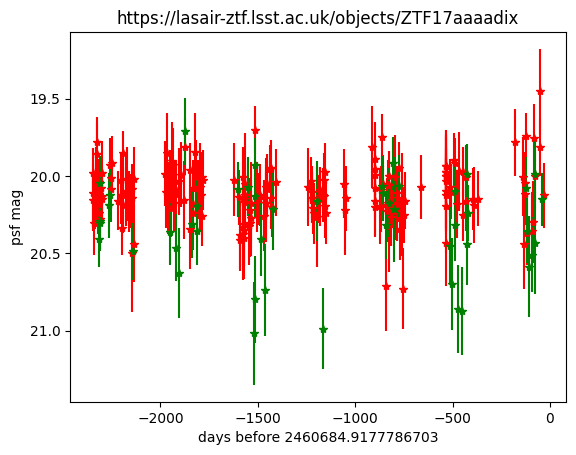

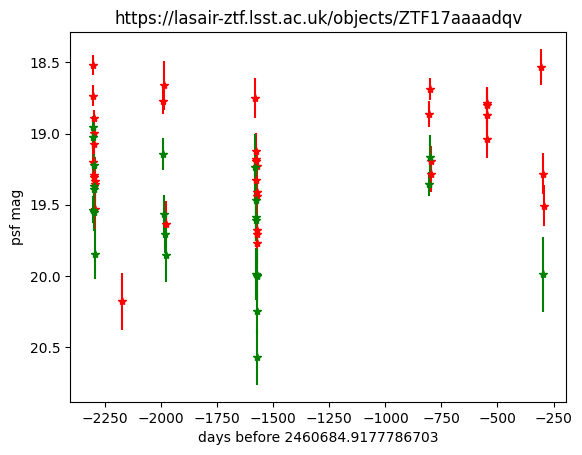

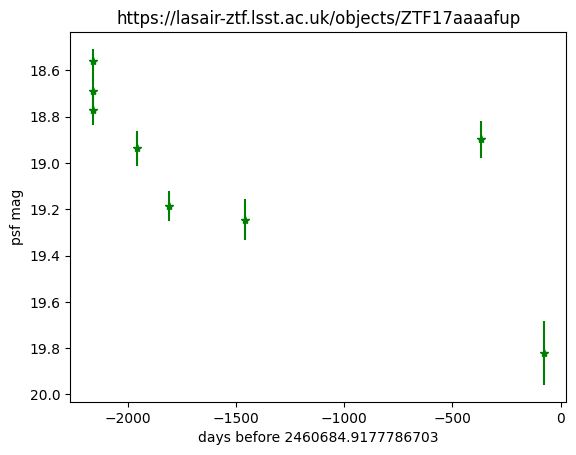

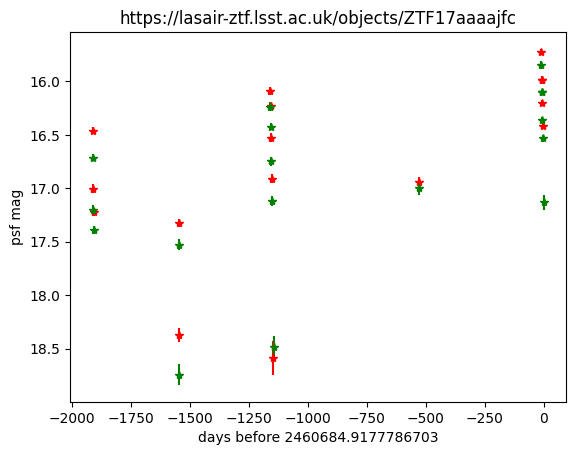

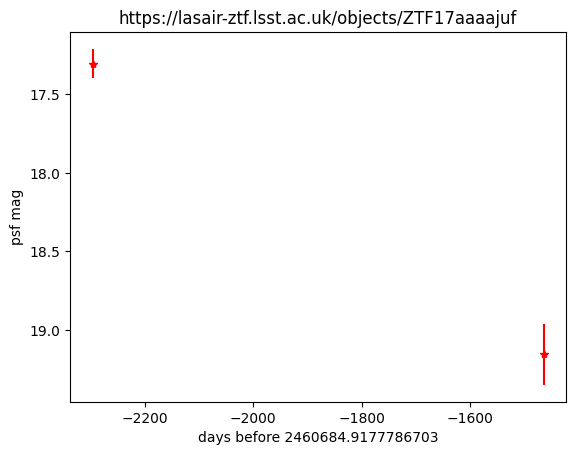

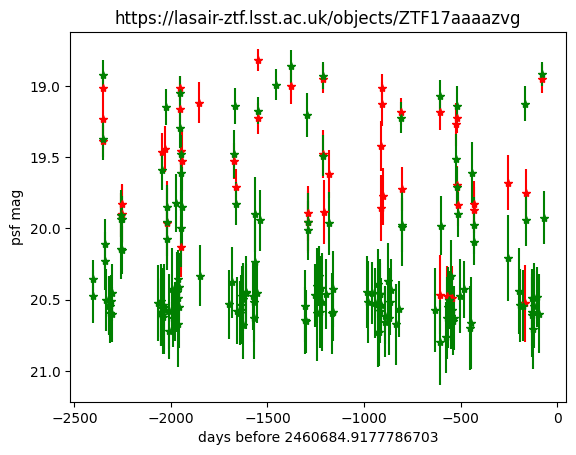

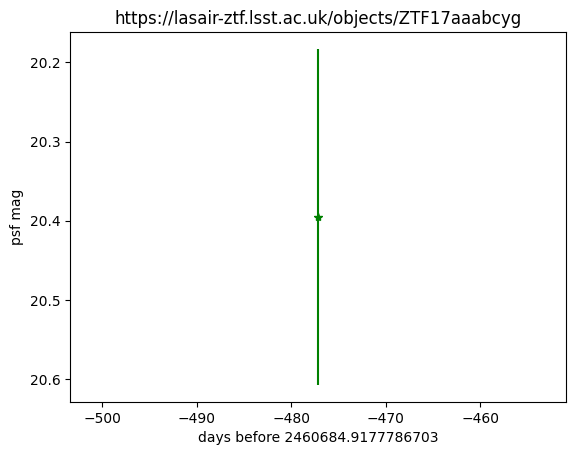

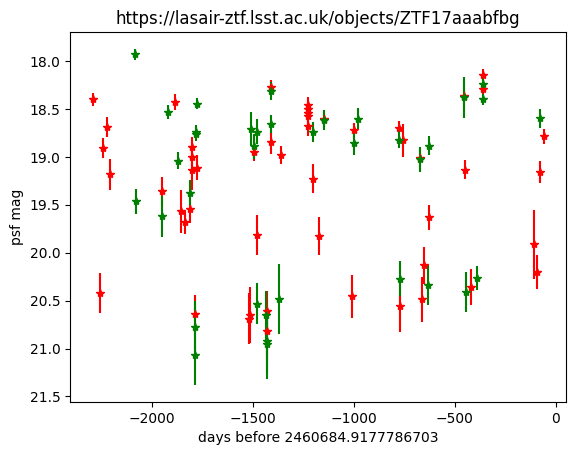

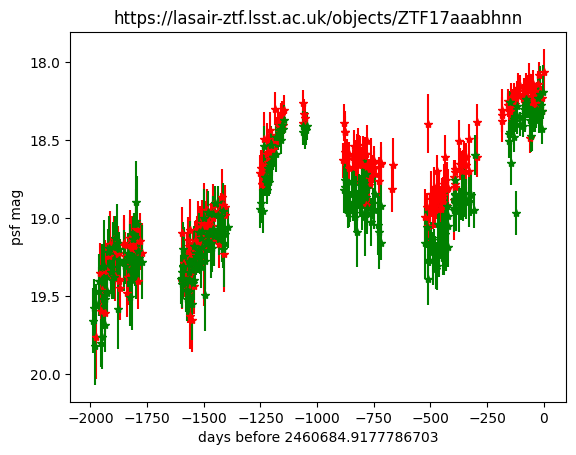

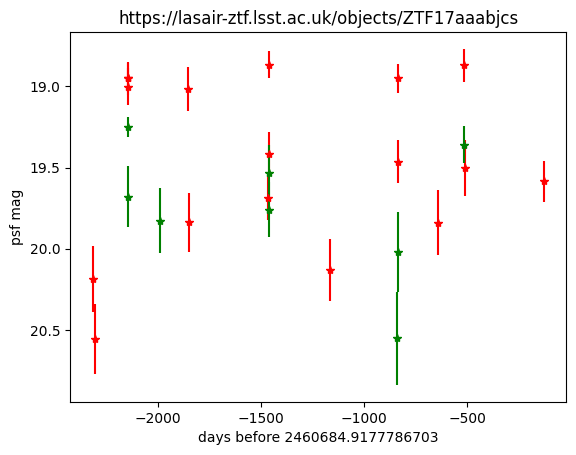

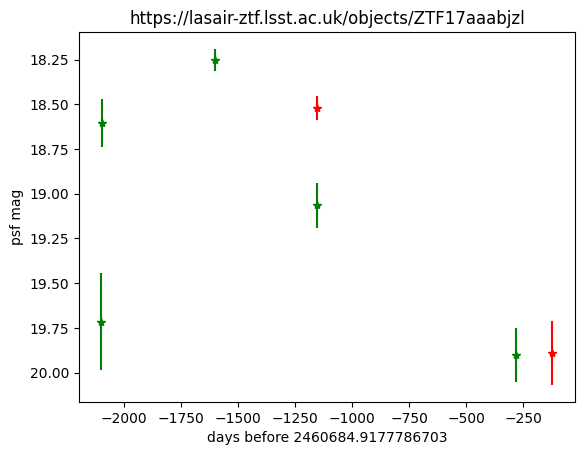

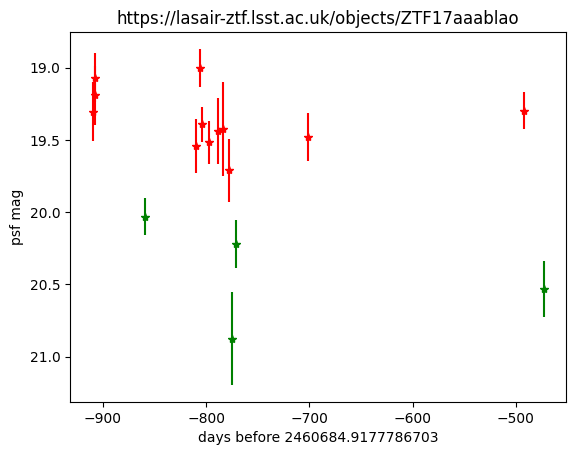

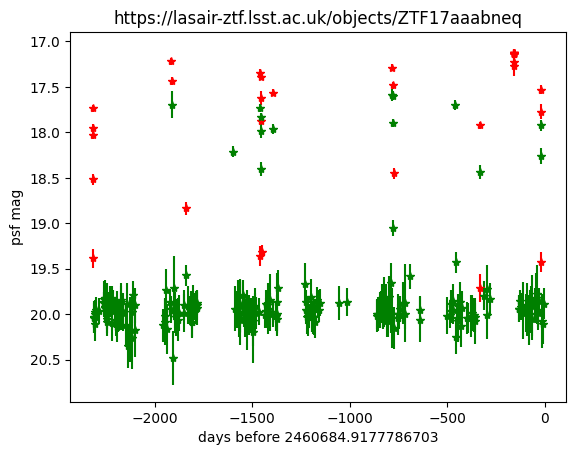

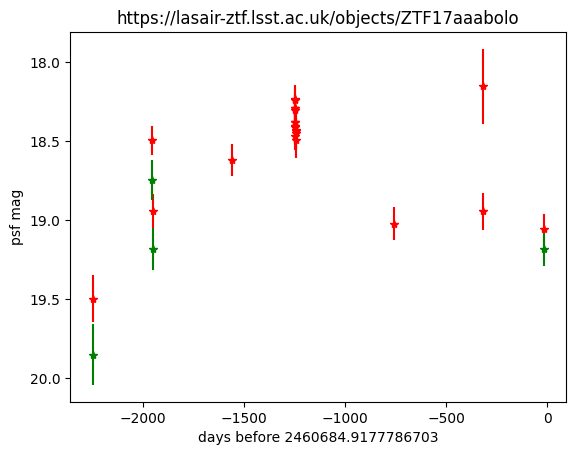

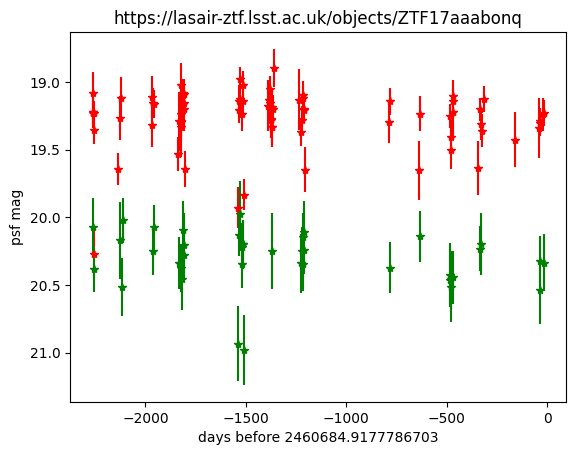

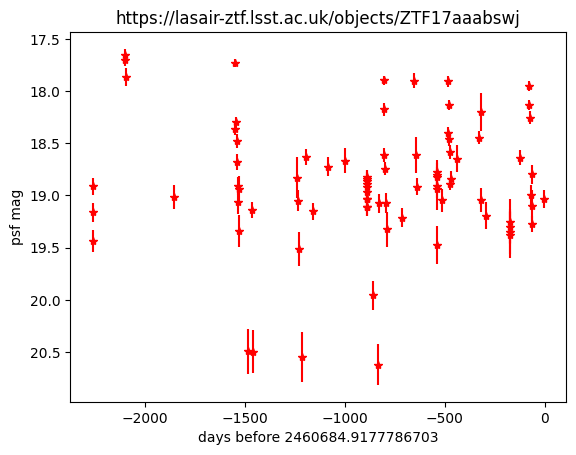

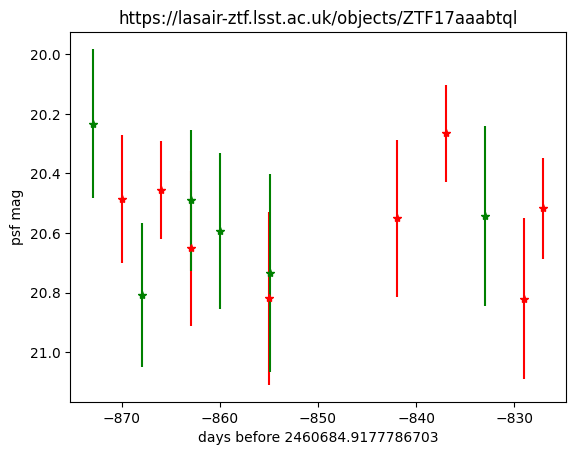

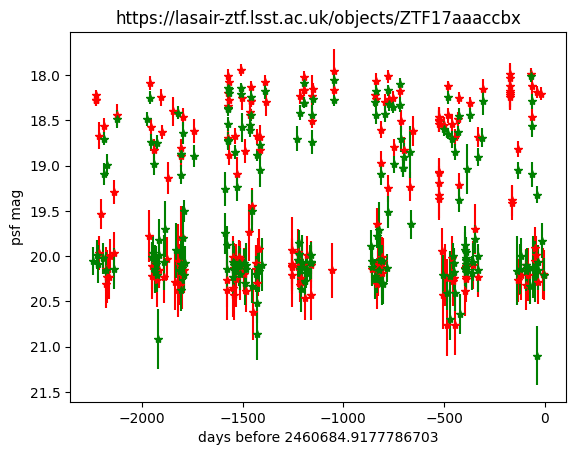

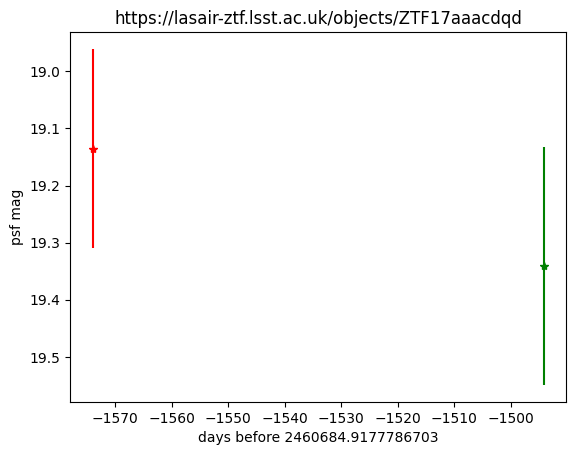

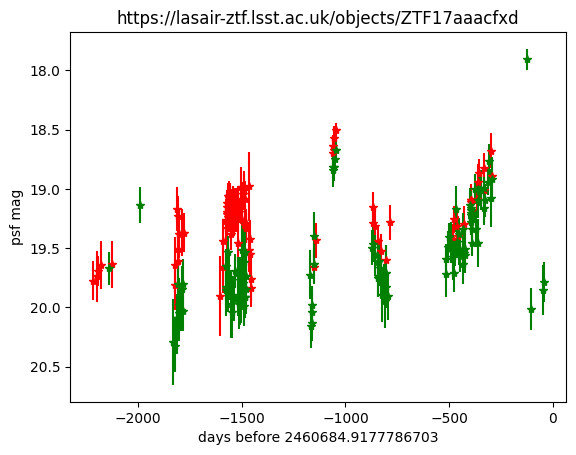

In [21]:
jd_now = now = Time.now().jd
for i in range(len(response)):
    # first we can save our object's name to a variable 
    objectId = response[i]['objectId']
    # Then we can use pandas DataFrames to neatly format our lightcurve
    df = pd.DataFrame(response[i]['candidates']) 
    # let's add a column to our dataframe
    df['phase'] = df.jd.values - jd_now
    
    _red_det_mask = (df.fid==2) & ~df.candid.isna()
    _red_nondet_mask = (df.fid==2) & df.candid.isna()
    _green_det_mask = (df.fid==1) & ~df.candid.isna()
    _green_nondet_mask = (df.fid==1) & df.candid.isna()

    # Plot the detections
    plt.errorbar(df['phase'].values[_red_det_mask], 
                 df['magpsf'].values[_red_det_mask],
                 yerr = df['sigmapsf'].values[_red_det_mask],
                 color = 'red', 
                 marker='*',
                 ls = ' '
                )

    plt.errorbar(df['phase'].values[_green_det_mask], 
                 df['magpsf'].values[_green_det_mask],
                 yerr = df['sigmapsf'].values[_green_det_mask],
                 color = 'green', 
                 marker='*',
                 ls = ' '
                )

    plt.title(f'https://lasair-ztf.lsst.ac.uk/objects/{objectId}')

    plt.gca().invert_yaxis()
    plt.xlabel(f"days before {jd_now}")
    plt.ylabel("psf mag")
    plt.show()